Enter UniProt ID: Q12840
 Downloaded structure for Q12840

 Total amino acids in Q12840: 1032

 Top 10 amino acids:
GLU (Glutamic Acid): 118
LEU (Leucine): 104
LYS (Lysine): 91
SER (Serine): 82
ALA (Alanine): 67
GLN (Glutamine): 65
VAL (Valine): 60
ARG (Arginine): 55
ASP (Aspartic Acid): 54
THR (Threonine): 51


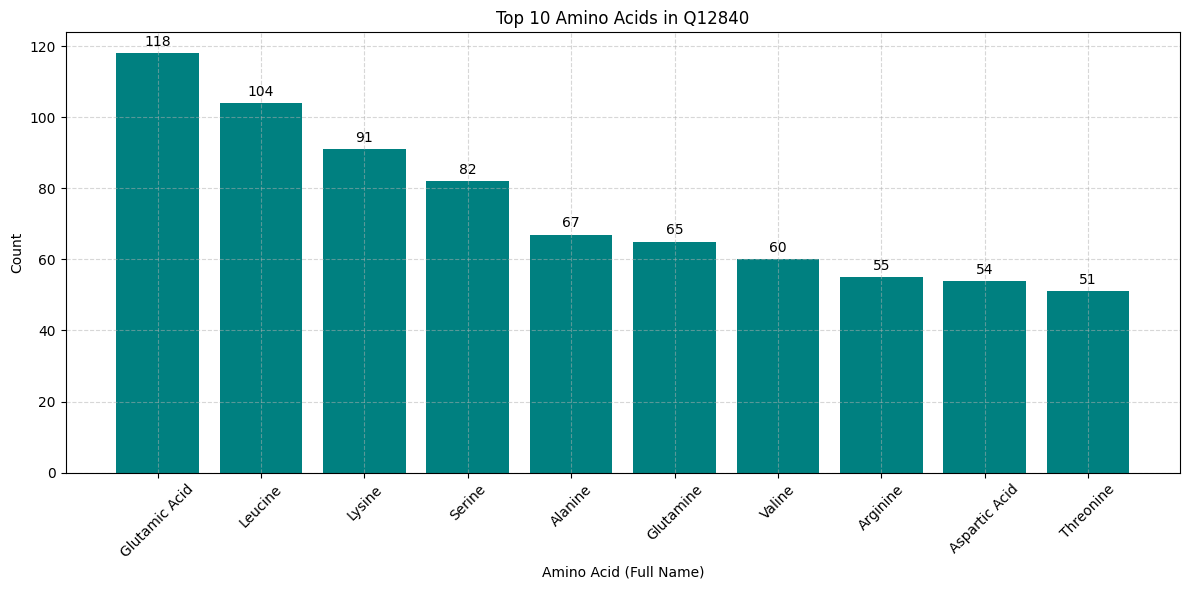


 Sequence length: 1032 bases

 Nucleotide content:
A: 67 (37.64%)
T: 51 (28.65%)
G: 45 (25.28%)
C: 15 (8.43%)
AT content: 118 (66.29%)
GC content: 60 (33.71%)


In [ ]:
# Install required libraries (Uncomment if running in Colab or first time)
# !pip install biopython

from Bio.PDB import PDBParser
from collections import Counter
import os
import requests
import matplotlib.pyplot as plt

# Full names of amino acids
aa_full_names = {
    'ALA': 'Alanine', 'ARG': 'Arginine', 'ASN': 'Asparagine', 'ASP': 'Aspartic Acid',
    'CYS': 'Cysteine', 'GLN': 'Glutamine', 'GLU': 'Glutamic Acid', 'GLY': 'Glycine',
    'HIS': 'Histidine', 'ILE': 'Isoleucine', 'LEU': 'Leucine', 'LYS': 'Lysine',
    'MET': 'Methionine', 'PHE': 'Phenylalanine', 'PRO': 'Proline', 'SER': 'Serine',
    'THR': 'Threonine', 'TRP': 'Tryptophan', 'TYR': 'Tyrosine', 'VAL': 'Valine'
}

# Function to download AlphaFold model
def download_af_model(uniprot_id):
    url = f"https://alphafold.ebi.ac.uk/files/AF-{uniprot_id}-F1-model_v4.pdb"
    response = requests.get(url)
    if response.status_code == 200:
        filename = f"AF-{uniprot_id}-F1-model_v4.pdb"
        with open(filename, "wb") as f:
            f.write(response.content)
        print(f" Downloaded structure for {uniprot_id}")
        return filename
    else:
        print(f" No structure found for UniProt ID: {uniprot_id}")
        return None

# Function to get DNA sequence from UniProt
def get_gene_sequence(uniprot_id):
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.fasta?format=fasta&includeIsoform=true"
    response = requests.get(url)
    if response.status_code == 200:
        fasta_data = response.text
        lines = fasta_data.strip().split('\n')
        seq = ''.join(lines[1:]).upper()
        return seq
    else:
        print(f" Could not fetch DNA/protein sequence for {uniprot_id}")
        return None




# Ask user for UniProt ID
uniprot_id = input("Enter UniProt ID: ").strip().upper()

# Download and parse structure
pdb_file = download_af_model(uniprot_id)
if pdb_file:
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(uniprot_id, pdb_file)

    # Count standard amino acids
    amino_acids = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.get_id()[0] == " ":
                    amino_acids.append(residue.get_resname())

    # Total count
    total_count = len(amino_acids)
    print(f"\n Total amino acids in {uniprot_id}: {total_count}")

    # Top 10 amino acids
    aa_counts = Counter(amino_acids)
    print("\n Top 10 amino acids:")
    for aa, count in aa_counts.most_common(10):
        full_name = aa_full_names.get(aa, aa)
        print(f"{aa} ({full_name}): {count}")

    # Bar plot of top 10 amino acids
    top_aa = aa_counts.most_common(10)
    labels = [aa_full_names.get(aa, aa) for aa, _ in top_aa]
    values = [count for _, count in top_aa]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(labels, values, color='teal')
    plt.title(f"Top 10 Amino Acids in {uniprot_id}")
    plt.xlabel("Amino Acid (Full Name)")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)

    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Get DNA/protein sequence and compute nucleotide stats
sequence = get_gene_sequence(uniprot_id)
if sequence:
    print(f"\n Sequence length: {len(sequence)} bases")
    base_counts = Counter(base for base in sequence if base in "ATGC")
    a = base_counts.get('A', 0)
    t = base_counts.get('T', 0)
    g = base_counts.get('G', 0)
    c = base_counts.get('C', 0)
    total = a + t + g + c

    if total > 0:
        at = a + t
        gc = g + c
        print(f"\n Nucleotide content:")
        print(f"A: {a} ({(a/total)*100:.2f}%)")
        print(f"T: {t} ({(t/total)*100:.2f}%)")
        print(f"G: {g} ({(g/total)*100:.2f}%)")
        print(f"C: {c} ({(c/total)*100:.2f}%)")
        print(f"AT content: {at} ({(at/total)*100:.2f}%)")
        print(f"GC content: {gc} ({(gc/total)*100:.2f}%)")
    else:
        print(" The sequence might be a protein (not DNA), as it lacks A/T/G/C.")

In [ ]:
import requests

def get_cadd_score(chrom, pos, ref, alt, cadd_version="GRCh38-v1.7"):
    """
    Fetches the CADD Phred score for a given variant using the CADD API.

    Args:
        chrom (str): Chromosome number (e.g., '1', 'X').
        pos (int): Genomic position (1-based).
        ref (str): Reference allele.
        alt (str): Alternate allele.
        cadd_version (str): The CADD version to use (e.g., "GRCh38-v1.7").

    Returns:
        float or None: The CADD Phred score if found, otherwise None.
    """
    # Base URL for the CADD API
    # Using the specific SNV access format: <chrom>:<pos>_<ref>_<alt>
    api_url = f"https://cadd.gs.washington.edu/api/v1.0/{cadd_version}/{chrom}:{pos}_{ref}_{alt}"

    print(f"Attempting to fetch CADD score from: {api_url}")

    try:
        response = requests.get(api_url)
        response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)

        data = response.json()

        if data:
            # The API returns a list, even for a single variant query.
            # We expect a single dictionary in the list for a specific variant query.
            variant_data = data[0]
            if "PHRED" in variant_data:
                return float(variant_data["PHRED"])
            else:
                print(f"PHRED score not found in response for {chrom}:{pos}_{ref}_{alt}")
                return None
        else:
            print(f"No data returned for variant {chrom}:{pos}_{ref}_{alt}. It might not be in the CADD database or the variant details are incorrect.")
            return None

    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err} - Status Code: {response.status_code} for {chrom}:{pos}_{ref}_{alt}")
        print(f"Response content: {response.text}")
        return None
    except requests.exceptions.ConnectionError as conn_err:
        print(f"Connection error occurred: {conn_err}. Check your internet connection.")
        return None
    except requests.exceptions.Timeout as timeout_err:
        print(f"Timeout error occurred: {timeout_err}. The request took too long.")
        return None
    except requests.exceptions.RequestException as req_err:
        print(f"An unexpected error occurred: {req_err}")
        return None
    except ValueError as json_err:
        print(f"Error parsing JSON response: {json_err}. Response content: {response.text}")
        return None

def main():
    """
    Main function to get user input and fetch CADD scores, then compare them.
    """
    print("--- CADD Value Finder for ALS Gene Variants ---")
    print("This tool fetches CADD Phred scores for specific gene variants.")
    print("You will need to provide Chromosome, Position, Reference Allele, and Alternate Allele for each variant.")
    print("You can find these details for ALS-related genes/variants on resources like Ensembl, NCBI Gene, or ClinVar.")
    print("-" * 50)

    gene_name = input("Enter the gene name (e.g., 'SOD1', 'C9orf72') for context: ").strip()

    while True:
        try:
            num_variants = int(input("How many variants would you like to check? "))
            if num_variants > 0:
                break
            else:
                print("Please enter a positive number.")
        except ValueError:
            print("Invalid input. Please enter a number.")

    variants_to_check = []
    for i in range(num_variants):
        print(f"\n--- Variant {i + 1} ---")
        chrom = input("Enter Chromosome (e.g., '1', 'X'): ").strip()
        pos = input("Enter Position (e.g., '12345678'): ").strip()
        ref = input("Enter Reference Allele (e.g., 'A', 'T', 'C', 'G'): ").strip().upper()
        alt = input("Enter Alternate Allele (e.g., 'A', 'T', 'C', 'G'): ").strip().upper()

        if not all([chrom, pos, ref, alt]):
            print("All fields are required. Skipping this variant.")
            continue

        try:
            pos = int(pos)
        except ValueError:
            print("Invalid position. Position must be a number. Skipping this variant.")
            continue

        variants_to_check.append({
            "chrom": chrom,
            "pos": pos,
            "ref": ref,
            "alt": alt,
            "cadd_score": None # Initialize CADD score to None
        })

    print(f"\n--- Fetching CADD scores for variants related to {gene_name} ---")
    for i, variant in enumerate(variants_to_check):
        print(f"\nVariant {i + 1}: Chrom={variant['chrom']}, Pos={variant['pos']}, Ref={variant['ref']}, Alt={variant['alt']}")
        cadd_score = get_cadd_score(
            variant["chrom"],
            variant["pos"],
            variant["ref"],
            variant["alt"]
        )
        variants_to_check[i]["cadd_score"] = cadd_score # Store the fetched score

        if cadd_score is not None:
            print(f"  CADD Phred Score: {cadd_score:.3f}")
            print("  (Higher scores indicate higher deleteriousness/pathogenicity)")
        else:
            print("  Could not retrieve CADD Phred Score for this variant.")

    print("\n--- Comparison of Variants ---")
    if len(variants_to_check) > 1:
        # Filter out variants for which CADD score could not be retrieved
        scored_variants = [v for v in variants_to_check if v["cadd_score"] is not None]

        if scored_variants:
            # Find the variant with the maximum CADD score
            most_pathogenic_variant = max(scored_variants, key=lambda x: x["cadd_score"])

            print("\nSummary of CADD Scores:")
            for i, variant in enumerate(variants_to_check):
                if variant["cadd_score"] is not None:
                    print(f"  Variant {i + 1} (Chrom={variant['chrom']}, Pos={variant['pos']}, Ref={variant['ref']}, Alt={variant['alt']}): CADD Phred Score = {variant['cadd_score']:.3f}")
                else:
                    print(f"  Variant {i + 1} (Chrom={variant['chrom']}, Pos={variant['pos']}, Ref={variant['ref']}, Alt={variant['alt']}): CADD Phred Score = Not Available")

            print(f"\nBased on CADD Phred Scores, the most likely more pathogenic variant is:")
            print(f"  Chrom: {most_pathogenic_variant['chrom']}")
            print(f"  Pos: {most_pathogenic_variant['pos']}")
            print(f"  Ref: {most_pathogenic_variant['ref']}")
            print(f"  Alt: {most_pathogenic_variant['alt']}")
            print(f"  CADD Phred Score: {most_pathogenic_variant['cadd_score']:.3f}")
            print("\nNote: Higher CADD Phred scores indicate a greater likelihood of deleteriousness or pathogenicity.")
        else:
            print("No CADD scores were successfully retrieved for comparison.")
    elif len(variants_to_check) == 1 and variants_to_check[0]["cadd_score"] is not None:
        print("\nOnly one variant was checked. No comparison needed.")
    else:
        print("No variants were successfully processed or had CADD scores for comparison.")


    print("\n--- Process Complete ---")

if __name__ == "__main__":
    main()


--- CADD Value Finder for ALS Gene Variants ---
This tool fetches CADD Phred scores for specific gene variants.
You will need to provide Chromosome, Position, Reference Allele, and Alternate Allele for each variant.
You can find these details for ALS-related genes/variants on resources like Ensembl, NCBI Gene, or ClinVar.
--------------------------------------------------
Enter the gene name (e.g., 'SOD1', 'C9orf72') for context: kif5a
How many variants would you like to check? 2

--- Variant 1 ---
Enter Chromosome (e.g., '1', 'X'): 12
Enter Position (e.g., '12345678'): 57550205
Enter Reference Allele (e.g., 'A', 'T', 'C', 'G'): C
Enter Alternate Allele (e.g., 'A', 'T', 'C', 'G'): G

--- Variant 2 ---
Enter Chromosome (e.g., '1', 'X'): 12
Enter Position (e.g., '12345678'): 57550224
Enter Reference Allele (e.g., 'A', 'T', 'C', 'G'): C
Enter Alternate Allele (e.g., 'A', 'T', 'C', 'G'): T

--- Fetching CADD scores for variants related to kif5a ---

Variant 1: Chrom=12, Pos=57550205, Ref=C